In [28]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
from scipy.signal import butter,lfilter
from scipy.fft import fft,ifft
import pandas as pd
import os
import glob
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, GlobalMaxPooling1D, Conv1D, Conv2D, Embedding, LSTM, MaxPooling2D, Flatten, InputLayer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
import datetime
import time
from tensorflow.keras.applications import EfficientNetB0
import torch
from tensorflow.keras.utils import Sequence
import math
from random import shuffle

!pip install nnAudio

In [29]:
file_path = "../input/g2net-gravitational-wave-detection/{}/{}/{}/{}/{}.npy"
targets = pd.read_csv('../input/g2net-gravitational-wave-detection/training_labels.csv')
sample_submission = pd.read_csv('../input/g2net-gravitational-wave-detection/sample_submission.csv')

In [30]:
fs = 2048
steps_per_second = 32
upsamp = fs//steps_per_second
min_width = max((0.1,steps_per_second/500))
max_width = steps_per_second/20
widths = np.arange(min_width, max_width, (max_width-min_width)/64)
n_samples = 100000

def get_signal_id(i):
    return targets.iloc[i]['id']

def get_signal(id_no,is_train=True):
    d0 = str(id_no)[0]
    d1 = str(id_no)[1]
    d2 = str(id_no)[2]
    if is_train:
        file = file_path.format('train',d0,d1,d2,id_no)
    else:
        file = file_path.format('test',d0,d1,d2,id_no)
    signal = np.load(file)
    return signal

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def filter_scale_signal(signal):
    sigs = []
    for s in signal:
        tmp = butter_bandpass_filter(s, 20, 500, fs, order=5)
        tmp = 2*(tmp - min(tmp))/(max(tmp)-min(tmp))-1
        sigs.append(tmp)
    return sigs

def get_scalogram(id_no,is_train):
    
    signal = get_signal(id_no,is_train=is_train)
    
    sigs = np.hstack(filter_scale_signal(signal))
       
    cwts = sig.cwt(sigs[0:-1:upsamp], sig.ricker, widths)
    
    return cwts.reshape((cwts.shape[0],cwts.shape[1],1))#out_mat = np.zeros((cwts.shape[0],cwts.shape[1]))

def get_model():
    tmp = get_spectrogram(get_signal_id(0),True)
    #tmp = get_scalogram(get_signal_id(0),True)
    layers = [
              InputLayer(input_shape=(tmp.shape[0],tmp.shape[1],1)),
              Conv2D(3,3,activation='relu',padding='same'),
              #Conv2D(16,(3,3),activation='relu',padding='same'),
              EfficientNetB0(include_top=False,input_shape=(),weights='imagenet'),      
              GlobalAveragePooling2D(),#pool_size=(2,2)),
              #Dropout(0.25),
              #Flatten(),
              Dense(32,activation='relu'),
              #Dropout(0.5),
              Dense(1,activation='sigmoid')]
    model = Sequential(layers)
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    #opt = tf.keras.optimizers.Adadelta(learning_rate=0.0001)
    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=[tf.keras.metrics.AUC(),
                           'accuracy'])
    
    model.summary()
    return model


from nnAudio.Spectrogram import CQT1992v2
def get_spectrogram(idx,is_train,transform=CQT1992v2(sr=2048, fmin=20, fmax=1024, hop_length=64)): # in order to use efficientnet we need 3 dimension images
    waves = get_signal(idx,is_train=is_train)
    waves = np.hstack(waves)
    waves = waves / np.max(waves)
    waves = torch.from_numpy(waves).float()
    image = transform(waves)
    image = np.array(image)
    image = np.transpose(image,(1,2,0))
    return image

class Dataset(Sequence):
    def __init__(self,idx,y=None,batch_size=256,shuffle=True):
        self.idx = idx
        self.batch_size = batch_size
        self.shuffle = shuffle
        if y is not None:
            self.is_train=True
        else:
            self.is_train=False
        self.y = y
    def __len__(self):
        return math.ceil(len(self.idx)/self.batch_size)
    def __getitem__(self,ids):
        batch_ids = self.idx[ids * self.batch_size:(ids + 1) * self.batch_size]
        if self.y is not None:
            batch_y = self.y[ids * self.batch_size: (ids + 1) * self.batch_size]
            
        list_x = np.array([get_spectrogram(x,self.is_train) for x in batch_ids])
        #list_x = np.array([get_scalogram(x,self.is_train) for x in batch_ids])
        
        batch_X = np.stack(list_x)
        if self.is_train:
            return batch_X, batch_y
        else:
            return batch_X
    
    def on_epoch_end(self):
        if self.shuffle and self.is_train:
            ids_y = list(zip(self.idx, self.y))
            shuffle(ids_y)
            self.idx, self.y = list(zip(*ids_y))

CQT kernels created, time used = 0.0205 seconds


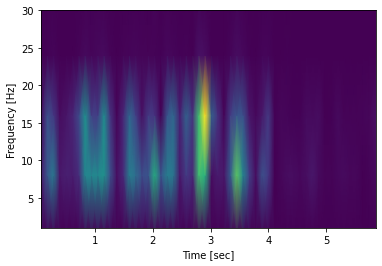

(129, 54)

In [31]:
f, t, Sxx = sig.spectrogram(np.hstack(get_signal(get_signal_id(0))), fs)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(1,30)
plt.show()
Sxx.shape

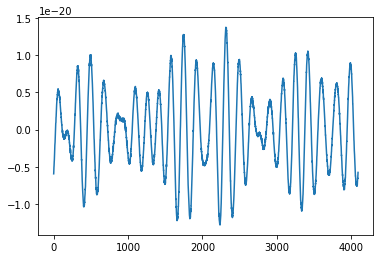

In [32]:
plt.plot(get_signal(get_signal_id(0))[0])

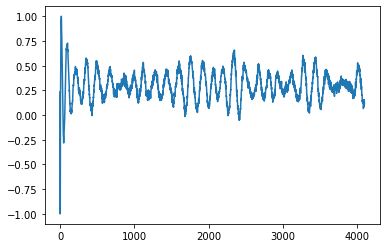

In [33]:
plt.plot(filter_scale_signal(get_signal(get_signal_id(0)))[0])

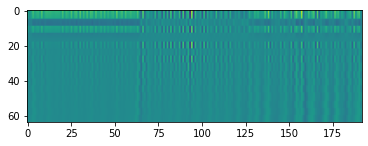

(64, 192, 1)

In [34]:
cwtmatr = get_scalogram(get_signal_id(0),True)
#plt.imshow(cwtmatr, extent=[0, 6, min_width, max_width], cmap='PRGn', aspect='auto',
#           vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
plt.imshow(cwtmatr)
plt.show()

cwtmatr.shape

(69, 193, 1)

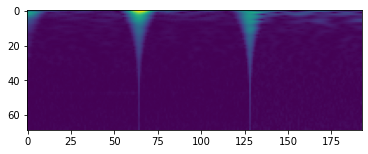

In [35]:
spect = get_spectrogram(get_signal_id(0),True)
plt.imshow(spect)
spect.shape

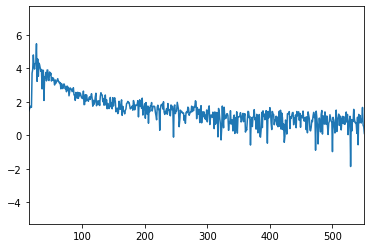

In [36]:
plt.plot(np.log(abs(fft(filter_scale_signal(get_signal(get_signal_id(0)))[0]))))
plt.xlim(15,550)
plt.show()

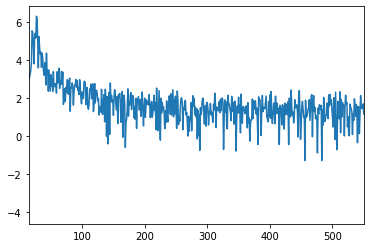

In [37]:
plt.plot(np.log(abs(fft(filter_scale_signal(get_signal(get_signal_id(1)))[0]))))
plt.xlim(15,550)
plt.show()

In [42]:
target_samp = targets#targets.sample(100000)
train_idx =  target_samp['id'].values
y = target_samp['target'].values
test_idx = sample_submission['id'].values
x_train,x_valid,y_train,y_valid = train_test_split(train_idx,y,test_size=0.05,random_state=42,stratify=y)

train_dataset = Dataset(x_train,y_train)
valid_dataset = Dataset(x_valid,y_valid)
test_dataset = Dataset(test_idx)

model = get_model()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 69, 193, 3)        30        
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1280)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)                40992     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 4,090,626
Trainable params: 4,048,603
Non-trainable params: 42,023
_________________________________________________________________


In [43]:
model.fit(train_dataset,
          epochs=1,
          validation_data=valid_dataset)

2079/2079 [==============================] - 5657s 3s/step - loss: 0.6951 - auc_4: 0.5003 - accuracy: 0.5000 - val_loss: 0.6935 - val_auc_4: 0.4995 - val_accuracy: 0.4998


In [ ]:
preds = model.predict(test_dataset)
df = pd.DataFrame({'id':sample_submission['id'],'target':preds})
df.to_csv('submission.csv',index=False)